### Implementation of Content-based Filtering

In [246]:
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit.algorithms.item_knn import ItemItem
from sklearn.manifold import TSNE
import plotly.express as px
from scipy.stats import pearsonr

In [28]:
data_folder = 'data/'
user_item_ratings_reduced = pd.read_csv(f'{data_folder}user_ratings_reduced.csv')
user_item_ratings_reduced = user_item_ratings_reduced.drop(columns=["Unnamed: 0"])
item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
item_info = pd.read_csv(data_folder + 'games.csv')
item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
item_themes = pd.read_csv(data_folder + 'themes.csv')

In [29]:
user_item_rating_count = user_item_ratings_reduced.groupby('user').count()

In [30]:
min_rating_count = 10
user_rating_count = user_item_rating_count[user_item_rating_count['rating'] >= min_rating_count]

In [31]:
user_list_filtered = list(user_rating_count.index)

In [32]:
user_item_ratings_filtered = user_item_ratings_reduced[user_item_ratings_reduced['user'].isin(user_list_filtered)]

In [33]:
user_item_ratings_filtered.head()

,item,rating,user
1,203416,8.0,-=Yod@=-
2,271896,8.0,-=Yod@=-
3,38054,6.0,-=Yod@=-
4,312267,5.0,-=Yod@=-
5,68448,9.0,-=Yod@=-


### Preprocessing

In [41]:
# item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
# item_info = pd.read_csv(data_folder + 'games.csv')
# item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
# item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
# item_themes = pd.read_csv(data_folder + 'themes.csv')

In [35]:
item_info.rename(columns={'BGGId':'item'},inplace=True)

In [42]:
# get comeplete user-catalog data
user_item_complete = pd.merge(user_item_ratings_filtered, item_info, on='item', how='inner')

In [263]:
# item_info.info() 
# item_info[['GoodPlayers', 'Family', 'ImagePath']].head()
non_numerical_features = ['user', 'Name', 'Description', 'item', 'GoodPlayers', 'Family', 'ImagePath']

In [46]:
user_item_complete.columns

Index(['item', 'rating', 'user', 'Name', 'Description', 'YearPublished',
       'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers',
       'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers',
       'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime',
       'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings',
       'NumComments', 'NumAlternates', 'NumExpansions', 'NumImplementations',
       'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath',
       'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts',
       'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames',
       'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic',
       'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract',
       'Cat:Party', 'Cat:Childrens'],
      dtype='object')

In [48]:
# find a median rating for each user
median_rating = user_item_complete.groupby('user')['rating'].median().rename('median_rating').reset_index()

In [50]:
user_item_complete = pd.merge(user_item_complete, median_rating, on='user', how='inner')

In [53]:
user_item_complete.shape

(1228331, 51)

User-Item matrix has size (1_228_331, 51) after selecting users with >= `min_rating_count`

User-Item matrix has size (771_551, 51) after selecting items for users with rating higher than their mean rating

In [54]:
user_item_favourite = user_item_complete[user_item_complete['rating']>=user_item_complete['median_rating']]

In [60]:
user_item_favourite.drop(columns=non_numerical_features, inplace=True)

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_3937/1451119071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite.drop(columns=non_numerical_features, inplace=True)


In [67]:
user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_3937/4043889100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_3937/4043889100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)


In [137]:
user_representation = user_item_favourite.groupby('user').median().reset_index()

In [138]:
user_representation_wnames = user_representation['user']

In [140]:
user_representation_wnames

0         -=Yod@=-
1         -Johnny-
2           -mIDE-
3           -toni-
4        ...Hammer
           ...    
51144      zzyzxuk
51145     zzzabiss
51146       zzzhsm
51147      zzzoren
51148     zzzzzane
Name: user, Length: 51149, dtype: object

In [141]:
user_representation.drop(columns=['user'], inplace=True)

In [142]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
user_clusters = tsne.fit_transform(user_representation)
time_end = time.time()

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_3937/2369309741.py:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

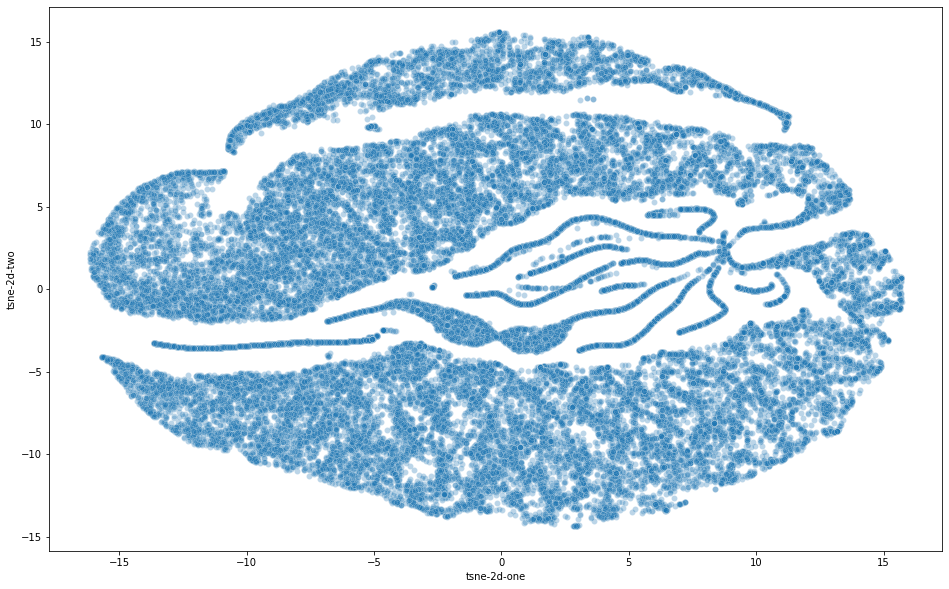

In [143]:
user_representation['tsne-2d-one'] = user_clusters[:,0]
user_representation['tsne-2d-two'] = user_clusters[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=user_representation,
    alpha=0.3,
)

In [144]:
fig = px.scatter(
    user_representation, x=user_representation['tsne-2d-one'], y=user_representation['tsne-2d-two'],
)
fig.show()

In [145]:
# manual cluster extraction using upper left and lower right points
group_1 = [(-11, 16), (12, 9.5)]
group_2 = [(-16, 9.5), (14, 0)]
group_3 = [(-15, 0), (15, -15)]

In [146]:
coords_groups = [group_1, group_2, group_3]
user_groups = []

for bounds in coords_groups:
    group_users = user_representation[(user_representation['tsne-2d-one'] >= bounds[0][0])&
                                      (user_representation['tsne-2d-one'] <= bounds[1][0])&
                                      (user_representation['tsne-2d-two'] <= bounds[0][1])&
                                      (user_representation['tsne-2d-two'] >= bounds[1][1])]
    user_groups.append(group_users)

In [234]:
group_1 = user_groups[0]
group_2 = user_groups[1]
group_3 = user_groups[2]

In [236]:
group_1 = pd.merge(group_1, user_representation_wnames, left_index=True, right_index=True, how='left')
group_2 = pd.merge(group_2, user_representation_wnames, left_index=True, right_index=True, how='left')
group_3 = pd.merge(group_3, user_representation_wnames, left_index=True, right_index=True, how='left')

In [237]:
def get_all_items_for_user(username, complete_df):
    return complete_df[complete_df['user']==username].drop(columns=['user'])  

In [239]:
group_1_users = group_1.user
group_2_users = group_2.user
group_3_users = group_3.user

In [240]:
group_1_itemids = user_item_complete[user_item_complete.user.isin(group_1_users)].item.unique()
group_1_items = user_item_complete[user_item_complete['item'].isin(group_1_itemids)]

group_2_itemids = user_item_complete[user_item_complete.user.isin(group_2_users)].item.unique()
group_2_items = user_item_complete[user_item_complete['item'].isin(group_2_itemids)]

group_3_itemids = user_item_complete[user_item_complete.user.isin(group_3_users)].item.unique()
group_3_items = user_item_complete[user_item_complete['item'].isin(group_3_itemids)]

In [229]:
def add_avg_group_rating(selected_items, group, complete):
    selected_items.reset_index(drop=True, inplace=True)
    selected_items['avg_group_rating'] = 0
    group_users = group['user'].unique()
    for index,item in selected_items.iterrows():
        item_in_group = complete[(complete['user'].isin(group_users))&(complete['item']==item['item'])]
        average_group_rating = item_in_group['rating'].mean()
        item['avg_group_rating'] = average_group_rating
        selected_items.iloc[index,:] = item
        
    return selected_items
        

In [241]:
item_group_1 = add_avg_group_rating(group_1_items.sample(frac=0.001, random_state=42), group_1, user_item_complete)
item_group_2 = add_avg_group_rating(group_2_items.sample(frac=0.001, random_state=42), group_2, user_item_complete)
item_group_3 = add_avg_group_rating(group_3_items.sample(frac=0.001, random_state=42), group_3, user_item_complete)
#item_group_1 = add_avg_group_rating(group_1_items.iloc[0:2,:], group_1, user_item_complete)

In [224]:
item_group_1[['Name','avg_group_rating']]

,Name,avg_group_rating
0,Exit: The Game – The Pharaoh's Tomb,7.393548
1,Star Wars: Outer Rim,7.894545


/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_3937/1858645688.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Group 3 Correlation of Features')

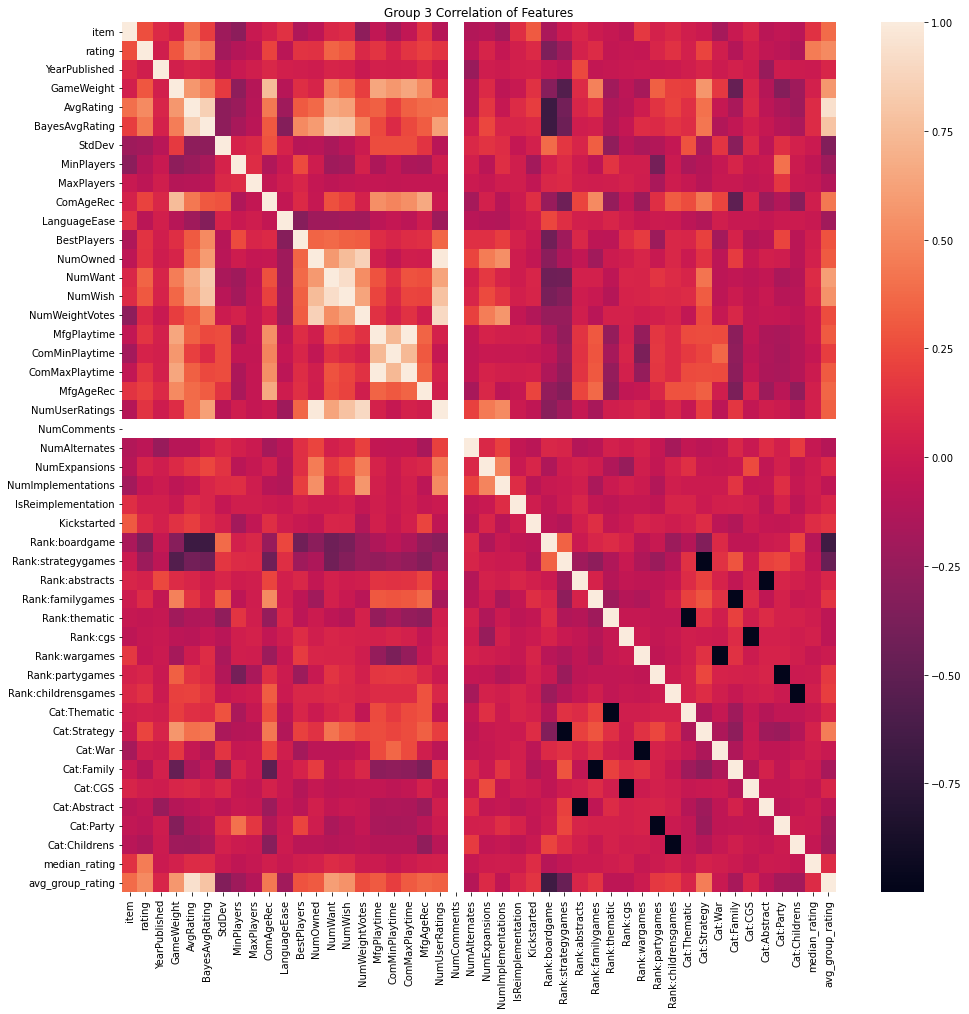

In [243]:
plt.figure(figsize=(16,16))
sns.heatmap(item_group_3.corr())
plt.title('Group 3 Correlation of Features')

In [279]:
def test_stat_significance(feature_name, selected_items):
    """ test whether an item feature has statistically significant 
        correlation (Pearson) with a group rating
    """

    feature = selected_items[feature_name].dropna()
    ratings = selected_items['avg_group_rating'].reindex(feature.index).values
    feature = feature.values
    
    _, p = pearsonr(ratings, feature)
    
    significant = False
    if p < 0.05:
        significant = True

    print(f'feature {feature_name} has p-value {round(p,2)}, significant: {significant}')
    return significant
    

In [280]:
test_stat_significance('MinPlayers',item_group_3)

feature MinPlayers has p-value 0.0, significant: True


True

In [261]:
item_group_3.columns

Index(['item', 'rating', 'user', 'Name', 'Description', 'YearPublished',
       'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers',
       'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers',
       'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime',
       'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings',
       'NumComments', 'NumAlternates', 'NumExpansions', 'NumImplementations',
       'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath',
       'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts',
       'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames',
       'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic',
       'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract',
       'Cat:Party', 'Cat:Childrens', 'median_rating', 'avg_group_rating'],
      dtype='object')

In [281]:
significant = []
for feature in item_group_3.columns:
    if feature not in non_numerical_features:
        print('feature:', feature)
        sign = test_stat_significance(feature,item_group_3)
        if sign:
            significant.append(feature)

feature: rating
feature rating has p-value 0.0, significant: True
feature: YearPublished
feature YearPublished has p-value 0.01, significant: True
feature: GameWeight
feature GameWeight has p-value 0.0, significant: True
feature: AvgRating
feature AvgRating has p-value 0.0, significant: True
feature: BayesAvgRating
feature BayesAvgRating has p-value 0.0, significant: True
feature: StdDev
feature StdDev has p-value 0.0, significant: True
feature: MinPlayers
feature MinPlayers has p-value 0.0, significant: True
feature: MaxPlayers
feature MaxPlayers has p-value 0.0, significant: True
feature: ComAgeRec
feature ComAgeRec has p-value 0.0, significant: True
feature: LanguageEase
feature LanguageEase has p-value 0.0, significant: True
feature: BestPlayers
feature BestPlayers has p-value 0.0, significant: True
feature: NumOwned
feature NumOwned has p-value 0.0, significant: True
feature: NumWant
feature NumWant has p-value 0.0, significant: True
feature: NumWish
feature NumWish has p-value 0.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [282]:
print(significant)

['rating', 'YearPublished', 'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers', 'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime', 'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation', 'Kickstarted', 'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts', 'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic', 'Cat:Strategy', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens', 'median_rating', 'avg_group_rating']
